# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Deep Learning. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import flickrapi

import string

from sklearn.preprocessing import *
from sklearn.pipeline import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import *

import os
import random

import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import log_loss
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [26]:
pic = np.transpose(pic, axes=(1, 0, 2))

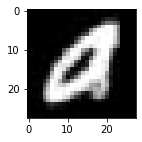

In [27]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

In [28]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [29]:
def get_dataset(data_dir, data_transforms, batch_num):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_num,
                                                 shuffle=True, num_workers=0)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [30]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 50)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
The datasest have:  {'train': 65000, 'test': 13000}  images


In [31]:
def imshow(img):
    img = img / 2 + 0.5      
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

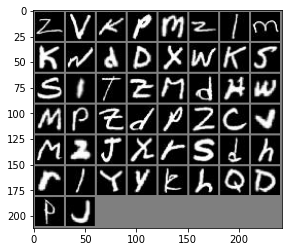

    z     v     k     p     m     z     l     m     k     n     d     d     x     w     k     s     s     i     t     z     m     d     h     w     m     p     z     d     p     z     c     v     m     z     j     x     y     s     d     h     r     l     y     y     k     h     q     d     p     j


In [32]:
# рассмотрим рандомные картинки
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = [np.transpose(pic, axes=(0, 2, 1)) for pic in images]
imshow(torchvision.utils.make_grid(images))
# выведем названия картинок
print(' '.join('%5s' % classes[labels[j]] for j in range(50)))

## 2 полносвязных (dense) скрытых слоя

In [44]:
# используем Relu
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 256),
            nn.ReLU(),
            nn.Linear(256, 26),
            nn.ReLU(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net = Net()

### lr=0.0001 batch_num = [200, 500, 1000] weight_decay=0

In [45]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.99))

In [46]:
acc_ = []
batch_num = [200, 500, 1000]

for batch in batch_num:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  200
[1,   100] loss: 2.268
[1,   200] loss: 1.234
[1,   300] loss: 0.970
[2,   100] loss: 0.810
[2,   200] loss: 0.747
[2,   300] loss: 0.695
Finished Training
Accuracy: 79 %
Batch size:  500
[1,   100] loss: 0.612
[2,   100] loss: 0.558
Finished Training
Accuracy: 82 %
Batch size:  1000
Finished Training
Accuracy: 83 %


Learning rate = 0.0001  --- 2 layers


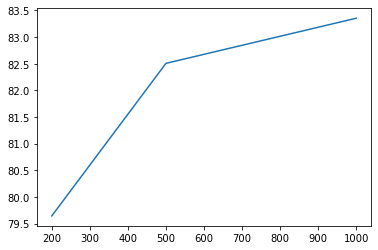

In [47]:
print("Learning rate = 0.0001  --- 2 layers")
plt.plot(batch_num, acc_)

Заметно, что с увеличением batch увеличивается Accuracy. Преимущественное значение оставим 1000.

### lr=0.0005 batch_num = [200, 500, 1000] weight_decay=0

In [207]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.99))
error_ = []

In [208]:
for batch in batch_num:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    error_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  200
[1,   100] loss: 0.500
[1,   200] loss: 0.486
[1,   300] loss: 0.445
[2,   100] loss: 0.352
[2,   200] loss: 0.354
[2,   300] loss: 0.352
Finished Training
Accuracy: 86 %
Batch size:  500
[1,   100] loss: 0.256
[2,   100] loss: 0.224
Finished Training
Accuracy: 87 %
Batch size:  1000
Finished Training
Accuracy: 88 %


Learning rate = 0.0005  --- 2 layers


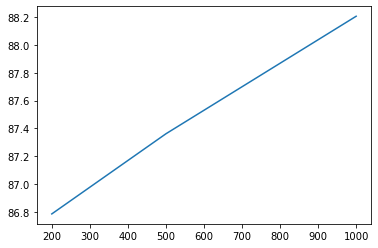

In [209]:
print("Learning rate = 0.0005  --- 2 layers")
plt.plot(batch_num, error_)

Мы увеличили значение Learning rate и Accuracy повысилась. Число batch 1000 всё ещё лидирует.

##### Изменили функции активации Sigmoid, batch_num = 1000, weight_decay=0

In [161]:
class Net_Sig(nn.Module):
    def __init__(self):
        super(Net_Sig, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 256),
            nn.Sigmoid(),
            nn.Linear(256, 26),
            nn.Sigmoid(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net_Sig = Net_Sig()

In [162]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)
optimizer = torch.optim.Adam(net_Sig.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [163]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_Sig(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 3.151
[1,    20] loss: 3.016
[1,    30] loss: 2.947
[1,    40] loss: 2.893
[1,    50] loss: 2.850
[1,    60] loss: 2.816
[2,    10] loss: 2.772
[2,    20] loss: 2.749
[2,    30] loss: 2.734
[2,    40] loss: 2.716
[2,    50] loss: 2.700
[2,    60] loss: 2.685
Finished Training


In [164]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_Sig(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 67 %


С Sigmoid заметно, что Accuracy снизилось почти на 20%.

##### Изменили функции активации Tanh, batch_num = 1000, weight_decay=0

In [165]:
class Net_Tanh(nn.Module):
    def __init__(self):
        super(Net_Tanh, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 256),
            nn.Tanh(),
            nn.Linear(256, 26),
            nn.Tanh(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net_Tanh = Net_Tanh()

In [166]:
optimizer = torch.optim.Adam(net_Tanh.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [167]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_Tanh(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.697
[1,    20] loss: 2.483
[1,    30] loss: 2.439
[1,    40] loss: 2.385
[1,    50] loss: 2.324
[1,    60] loss: 2.262
[2,    10] loss: 2.156
[2,    20] loss: 2.097
[2,    30] loss: 2.055
[2,    40] loss: 2.012
[2,    50] loss: 1.978
[2,    60] loss: 1.964
Finished Training


In [168]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_Tanh(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 72 %


С Tanh заметно, что Accuracy снизилось почти на 10%.

##### Изменили функцию активации обратно на Relu, изменили число нейронов, batch_num = 1000, weight_decay=0

In [169]:
class Net_numNeir(nn.Module):
    def __init__(self):
        super(Net_numNeir, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
            nn.ReLU(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net_numNeir = Net_numNeir()

In [170]:
optimizer = torch.optim.Adam(net_numNeir.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [171]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_numNeir(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.323
[1,    20] loss: 1.281
[1,    30] loss: 0.980
[1,    40] loss: 0.863
[1,    50] loss: 0.767
[1,    60] loss: 0.723
[2,    10] loss: 0.596
[2,    20] loss: 0.575
[2,    30] loss: 0.578
[2,    40] loss: 0.510
[2,    50] loss: 0.503
[2,    60] loss: 0.490
Finished Training


In [172]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_numNeir(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 84 %


Accuracy не сильно изменилась, когда мы поменяли число нейронов, поэтому оставим первую модель предпочтительной с числом batch равным 1000.

##### Изменили weight_decay

In [173]:
accur_ = []
weights = [0.0001, 0.0005]

for weight in weights:
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.99), weight_decay=weight)
    print('Weight_decay: ', weight)
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accur_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Weight_decay:  0.0001
[1,    10] loss: 0.161
[1,    20] loss: 0.174
[1,    30] loss: 0.183
[1,    40] loss: 0.167
[1,    50] loss: 0.180
[1,    60] loss: 0.186
[2,    10] loss: 0.148
[2,    20] loss: 0.146
[2,    30] loss: 0.163
[2,    40] loss: 0.158
[2,    50] loss: 0.164
[2,    60] loss: 0.154
Finished Training
Accuracy: 87 %
Weight_decay:  0.0005
[1,    10] loss: 0.139
[1,    20] loss: 0.158
[1,    30] loss: 0.153
[1,    40] loss: 0.162
[1,    50] loss: 0.161
[1,    60] loss: 0.161
[2,    10] loss: 0.131
[2,    20] loss: 0.139
[2,    30] loss: 0.146
[2,    40] loss: 0.145
[2,    50] loss: 0.153
[2,    60] loss: 0.154
Finished Training
Accuracy: 88 %


Learning rate = 0.0005, batch size = 1000  --- 2 layers


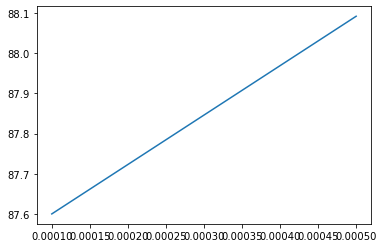

In [174]:
print("Learning rate = 0.0005, batch size = 1000  --- 2 layers")
plt.plot(weights, accur_)

При добавлении регуляризации качество нашей модели улучшилось, но не значительно.
Рассмотрим теперь 3 полносвязных (dense) скрытых слоя.

Везде число эпох равнялось 2, так как для количества эпох = 10 на подсчёт каждой модели уходило более 1 часа. При 10 качество модели улучшалось в среднем на 4-5%

## 3 полносвязных (dense) скрытых слоя

In [175]:
# Используем Relu
class Net_lay3(nn.Module):
    def __init__(self):
        super(Net_lay3, self).__init__()
        self.cnn_layers = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(2352),
        nn.Linear(28*28*3, 300),
        nn.ReLU(),
        nn.Linear(300, 200),
        nn.ReLU(),
        nn.Linear(200, 26),
        nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnn_layers(x)
        return x

net_lay3 = Net_lay3()

##### lr = 0.0001  batch_num = [50, 200, 500, 1000] weight_decay=0.0001

In [176]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net_lay3.parameters(), lr=0.0001, betas=(0.9, 0.99), weight_decay=0.0001)

In [177]:
acc = []
batch_num = [50, 200, 500, 1000]
error = []

for batch in batch_num:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    

    for epoch in range(2):
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
        
            optimizer.zero_grad()
    
            outputs = net_lay3(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                     (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
          
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_lay3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc.append(round(100 * correct) / total)
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
Finished Training
Accuracy: 83 %
Batch size:  200
Finished Training
Accuracy: 86 %
Batch size:  500
Finished Training
Accuracy: 87 %
Batch size:  1000
Finished Training
Accuracy: 87 %


В сравнение с 2мя полносвязными слоями Accuracy нашей модели осталась практически неизменной.

Learning rate = 0.0001  --- 3 layers


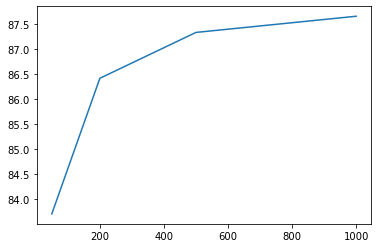

In [178]:
print("Learning rate = 0.0001  --- 3 layers")
plt.plot(batch_num, acc)

Как и с 2мя полносвязными слоями чем больше batch, тем выше Accuracy. Предпочтительным остается batch_size = 1000.

##### lr = 0.0005 batch_num = [500, 1000] weight_decay=0.0001

In [179]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net_lay3.parameters(), lr=0.0005, betas=(0.9, 0.99), weight_decay=0.0001)

In [180]:
acc = []
batch_num = [500, 1000]
  
for batch in batch_num:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    

    for epoch in range(2):
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
        
            optimizer.zero_grad()
    
            outputs = net_lay3(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                     (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
          
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_lay3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc.append(round(100 * correct) / total)
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  500
Finished Training
Accuracy: 87 %
Batch size:  1000
Finished Training
Accuracy: 88 %


Learning rate = 0.0001  --- 3 layers


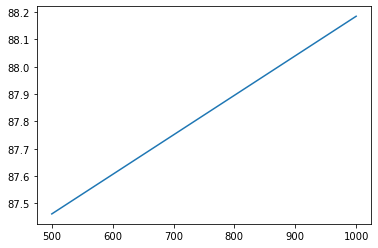

In [181]:
print("Learning rate = 0.0001  --- 3 layers")
plt.plot(batch_num, acc)

Изменение Learning rate в данном случае не сильно повлиял на Accuracy

##### Изменили функции активации, batch_num = [300, 500, 800, 1000], weight_decay=0

In [182]:
class Net_Tanh_lay3(nn.Module):
    def __init__(self):
        super(Net_Tanh_lay3, self).__init__()
        self.cnn_layers = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(2352),
        nn.Linear(28*28*3, 300),
        nn.Tanh(),
        nn.Linear(300, 200),
        nn.Tanh(),
        nn.Linear(200, 26),
        nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnn_layers(x)
        return x

net_Tanh_lay3 = Net_Tanh_lay3()

In [183]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits
optimizer = torch.optim.Adam(net_Tanh_lay3.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [184]:
acc = []
batch_num = [300, 500, 800, 1000]
  
for batch in batch_num:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    

    for epoch in range(2):
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
        
            optimizer.zero_grad()
    
            outputs = net_Tanh_lay3(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                     (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
          
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_Tanh_lay3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc.append(round(100 * correct) / total)
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  300
Finished Training
Accuracy: 83 %
Batch size:  500
Finished Training
Accuracy: 85 %
Batch size:  800
Finished Training
Accuracy: 86 %
Batch size:  1000
Finished Training
Accuracy: 87 %


Learning rate = 0.0001  --- 3 layers


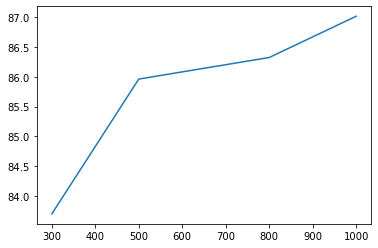

In [185]:
print("Learning rate = 0.0001  --- 3 layers")
plt.plot(batch_num, acc)

При использовании Tanh не изменилось Accuracy.

##### Изменили функцию активации обратно на Relu, изменили число нейронов, batch_num = 1000, weight_decay=0

In [186]:
class Net_numNeir_lay3(nn.Module):
    def __init__(self):
        super(Net_numNeir_lay3, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net_numNeir_lay3 = Net_numNeir_lay3()

In [187]:
err = []
optimizer = torch.optim.Adam(net_numNeir_lay3.parameters(), lr=0.0005, betas=(0.9, 0.99))
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)

In [188]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_numNeir_lay3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.545
[1,    20] loss: 1.326
[1,    30] loss: 1.002
[1,    40] loss: 0.849
[1,    50] loss: 0.736
[1,    60] loss: 0.673
[2,    10] loss: 0.558
[2,    20] loss: 0.523
[2,    30] loss: 0.495
[2,    40] loss: 0.478
[2,    50] loss: 0.456
[2,    60] loss: 0.462
Finished Training


In [189]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_numNeir_lay3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 85 %


При изменении числа нейронов Accuracy нашей модели с batch_size = 1000 понизилось по сравнению с более ранними моделями.

##### Изменили weight_decay = [0.0001, 0.0005, 0.001], lr = 0.005 batch_num = 1000. Ввозьмем модель net

In [191]:
weights = [0.0001, 0.0005, 0.001]
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)

In [192]:
accur = []

for weight in weights:
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.99), weight_decay=weight)
    print('Weight_decay: ', weight)
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net_lay3(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_lay3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accur.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Weight_decay:  0.0001
[1,    10] loss: 0.161
[1,    20] loss: 0.155
[1,    30] loss: 0.146
[1,    40] loss: 0.154
[1,    50] loss: 0.154
[1,    60] loss: 0.155
[2,    10] loss: 0.157
[2,    20] loss: 0.159
[2,    30] loss: 0.152
[2,    40] loss: 0.152
[2,    50] loss: 0.157
[2,    60] loss: 0.154
Finished Training
Accuracy: 88 %
Weight_decay:  0.0005
[1,    10] loss: 0.152
[1,    20] loss: 0.159
[1,    30] loss: 0.151
[1,    40] loss: 0.153
[1,    50] loss: 0.155
[1,    60] loss: 0.161
[2,    10] loss: 0.155
[2,    20] loss: 0.150
[2,    30] loss: 0.157
[2,    40] loss: 0.152
[2,    50] loss: 0.159
[2,    60] loss: 0.156
Finished Training
Accuracy: 88 %
Weight_decay:  0.001
[1,    10] loss: 0.159
[1,    20] loss: 0.156
[1,    30] loss: 0.161
[1,    40] loss: 0.151
[1,    50] loss: 0.148
[1,    60] loss: 0.157
[2,    10] loss: 0.156
[2,    20] loss: 0.156
[2,    30] loss: 0.159
[2,    40] loss: 0.152
[2,    50] loss: 0.150
[2,    60] loss: 0.156
Finished Training
Accuracy: 88 %


Learning rate = 0.0005, batch size = 1000  --- 3 layers


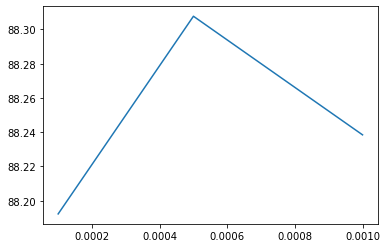

In [193]:
print("Learning rate = 0.0005, batch size = 1000  --- 3 layers")
plt.plot(weights, accur)

Видно, что при регуляризации оптимально использовать weight_decay = 0.0005.

Выберем наилучшей конфигурацией модель net (с 2мя полносвязными слоями). И с ней выполним оценку предсказаний для каждой буквы и для первой буквы моей фамилии (Соколова - 's').

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
images, labels = data

In [50]:
labels_all = []
pred_all = []
images_all = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        labels_all = labels_all + list(labels)
        pred_all = pred_all + list(predicted)
        for im in images:
            images_all.append(list(im))

In [51]:
cm = confusion_matrix(labels_all, pred_all)

In [52]:
print('Confusion matrix: ', cm[1:27, 0:25]) 

Confusion matrix:  [[  8 435   0  10   2   0  10   8   2   1   0   2   1   1   4   1   4   0
    3   0   1   0   0   1   0]
 [  4   0 453   0  23   0   1   0   1   2   1   1   0   0   8   0   1   3
    0   1   1   0   0   0   0]
 [  2  15   0 421   0   1   6   4   2   4   2   5   0   3  19   1   2   0
    1   1   4   0   2   0   0]
 [  3   5  22   0 441   2   3   1   1   1   2   1   0   1   1   0   1   3
    1   3   1   2   1   0   0]
 [  4   0   0   0   1 416   8   0   3   1   0   1   1   2   0  25   9   6
    1  18   0   0   0   0   3]
 [ 14  13   5   2   2   6 332   0   0   6   0   0   1   1   2   0  86   2
   13   2   2   1   1   0   8]
 [ 12   5   0   4   0   1   1 408   2   0  16   8   4  24   0   1   0   0
    0   2   3   1   2   5   1]
 [  0   0   0   2   2   3   2   0 355  16   0  86   0   0   0   0   2   3
    1   2   0   0   0   7   4]
 [  0   1   0  10   0   0   3   3  10 431   0   5   0   0   0   0   1   1
   12   8   6   2   1   0   2]
 [  3   9   1   1   0   4   0  18   

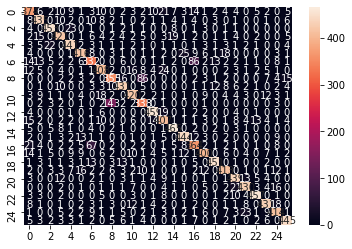

In [53]:
sns.heatmap(cm, annot=True, fmt="d")

In [54]:
cm.shape

(26, 26)

In [61]:
lttrs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
top_errors = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if (cm[i, j] > 10 and i != j):
            top_errors.append([cm[i, j], lttrs[i], lttrs[j], i, j])
top_errors.sort(reverse=True) ###
print('Top errors: ', top_errors)
        

num_pics = 10    
for i in range(len(top_errors)):
    if (num_pics > 0):
        print(top_errors[i][1], top_errors[i][2] )
#        print(images_all[top_errors[i][3]])
#        plt.imshow(np.array(images_all[top_errors[i][3]]).reshape((28, 28)).T, cmap='gray')
#        plt.show()
        num_pics-=1

Top errors:  [[143, 'l', 'i', 11, 8], [86, 'i', 'l', 8, 11], [86, 'g', 'q', 6, 16], [67, 'q', 'g', 16, 6], [25, 'f', 'p', 5, 15], [24, 'h', 'n', 7, 13], [23, 'y', 'v', 24, 21], [23, 'c', 'e', 2, 4], [22, 'e', 'c', 4, 2], [21, 'v', 'u', 21, 20], [21, 'q', 'a', 16, 0], [21, 'a', 'n', 0, 13], [19, 'm', 'n', 12, 13], [19, 'd', 'o', 3, 14], [18, 'x', 'y', 23, 24], [18, 'k', 'h', 10, 7], [18, 'f', 't', 5, 19], [16, 'v', 'y', 21, 24], [16, 't', 'f', 19, 5], [16, 'i', 'j', 8, 9], [16, 'h', 'k', 7, 10], [15, 'n', 'a', 13, 0], [15, 'i', 'z', 8, 25], [15, 'd', 'b', 3, 1], [14, 'r', 'a', 17, 0], [14, 'n', 'm', 13, 12], [14, 'g', 'a', 6, 0], [14, 'a', 'q', 0, 16], [13, 'u', 'v', 20, 21], [13, 's', 'j', 18, 9], [13, 's', 'g', 18, 6], [13, 'p', 'f', 15, 5], [13, 'n', 'w', 13, 22], [13, 'g', 's', 6, 18], [13, 'g', 'b', 6, 1], [12, 'x', 'k', 23, 10], [12, 'u', 'd', 20, 3], [12, 't', 'y', 19, 24], [12, 't', 'r', 19, 17], [12, 'r', 'p', 17, 15], [12, 'p', 'q', 15, 16], [12, 'k', 'x', 10, 23], [12, 'j', '

Мы видим, что топ-ошибок достаточно логичный, соответствующий реальности.

'i' и 'l' похожи, так как многие пишут 'i' без точки иногда или с плохо видимой точкой

In [56]:
correct = list(0. for i in range(len(classes)))
total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(1000):
            label = labels[i]
            correct[label] += c[i].item()
            total[label] += 1
print(correct)

[370.0, 437.0, 454.0, 423.0, 442.0, 415.0, 330.0, 407.0, 353.0, 429.0, 418.0, 337.0, 458.0, 404.0, 470.0, 444.0, 366.0, 404.0, 450.0, 419.0, 433.0, 428.0, 456.0, 431.0, 415.0, 446.0]


In [57]:
list_with_accuracies = [(classes[i], correct[i] / total[i]) for i in range(len(classes))]
list_with_accuracies.sort(key=lambda x: x[1], reverse=True)

for i in range(len(classes)):
    print('Precision of ', list_with_accuracies[i][0], ' = ', np.round(list_with_accuracies[i][1]*100, 1), '%', sep='')


Precision of o = 94.0%
Precision of m = 91.6%
Precision of w = 91.2%
Precision of c = 90.8%
Precision of s = 90.0%
Precision of z = 89.2%
Precision of p = 88.8%
Precision of e = 88.4%
Precision of b = 87.4%
Precision of u = 86.6%
Precision of x = 86.2%
Precision of j = 85.8%
Precision of v = 85.6%
Precision of d = 84.6%
Precision of t = 83.8%
Precision of k = 83.6%
Precision of f = 83.0%
Precision of y = 83.0%
Precision of h = 81.4%
Precision of n = 80.8%
Precision of r = 80.8%
Precision of a = 74.0%
Precision of q = 73.2%
Precision of i = 70.6%
Precision of l = 67.4%
Precision of g = 66.0%


И вновь достаточно логично, что хуже всего определяют такие буквы, как : 'l', 'i'.

In [65]:
pic = plt.imread('images/train/i/i_00220.jpg')
print(pic.shape)

(28, 28, 3)


In [66]:
pic = np.transpose(pic, axes=(1, 0, 2))

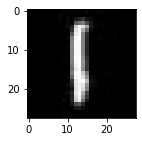

In [67]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

Пример плохо детектированной 'i'

In [220]:
j = 0
surname_errors = []
for i in range(len(lttrs)):
    if lttrs[i] == 's':
        j = i
j

18

In [221]:
surname_err_sum = 0
for i in range(cm.shape[1]):
    if (cm[i, j] > 5 and i != j):
        surname_err_sum += cm[i, j]
        surname_errors.append([cm[i, j], lttrs[i], lttrs[j], i, j])
surname_errors.sort(reverse=True) ###
print('Top errors: ',surname_errors)

 

num_pics = 10    
for i in range(len(surname_errors)):
    if (num_pics > 0):
        print(surname_errors[i][1], surname_errors[i][2] )
#         print(images_all[top_errors[i][3]])
#         plt.imshow(np.array(images_all[top_errors[i][3]]).reshape((28, 28)).T, cmap='gray')
#         plt.show()
        num_pics-=1
    
print ('Precision of the surname: ', 100 * (1 - surname_err_sum/total[j]))

Top errors:  [[9, 'g', 's', 6, 18], [6, 'j', 's', 9, 18]]
g s
j s
Precision of the surname:  97.0


Первая буква моей фамилии редко путается, чаще всего это происходит с буквами 'g', 'j', что также соответствует реальности.

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

#### First models 1, 2, 3

In [10]:
class ConvNet3(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet3, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
in_d = 1152
hidn = 500
out_d = 26    
ConvNet3 = ConvNet3(in_d, hidn, out_d)

class ConvNet2(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
in_d = 3136
hidn = 500
out_d = 26
ConvNet2 = ConvNet2(in_d, hidn, out_d)
        
class ConvNet1(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet1, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
in_d = 6272
hidn = 500
out_d = 26       
ConvNet1 = ConvNet1(in_d, hidn, out_d)

#### Second models 1_0, 2_0, 3_0

In [11]:
# лучшее число нейронов оказалось:
class ConvNet3_0(nn.Module):
    def __init__(self):
        super(ConvNet3_0, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1152, 500)
        self.fc2 = nn.Linear(500, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
ConvNet3_0 = ConvNet3_0()

class ConvNet2_0(nn.Module):
    def __init__(self):
        super(ConvNet2_0, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3136, 500)
        self.fc2 = nn.Linear(500, 26)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

ConvNet2_0 = ConvNet2_0()
        
class ConvNet1_0(nn.Module):
    def __init__(self):
        super(ConvNet1_0, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(6272, 500)
        self.fc2 = nn.Linear(500, 26)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        
ConvNet1_0 = ConvNet1_0()

#### ConvNet2 with BatchNorm

In [12]:
#500x3136 32x120
# После увидим, что модель с 2мя сверточными слоями является лучшей конфигурацией, поэтому определим использование ее с BatchNorm и GroupNorm 
class ConvNet2_BatchN(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2_BatchN, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1), 
            nn.Linear(in_features=3136, out_features=500), 
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(in_features=500, out_features=200),
            nn.ReLU(),
        )

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
in_d = 200
hidn = 100
out_d = 26
ConvNet2_BatchN = ConvNet2_BatchN(in_d, hidn, out_d)

#### ConvNet2 with GroupNorm

In [13]:
#500x3136 32x120
#RuntimeError: Expected number of channels in input 
#to be divisible by num_groups, but got input of shape [500, 3, 28, 28] and num_groups=32

#RuntimeError: Expected number of channels in input to be divisible by num_groups, but got input of
#shape [500, 32, 28, 28] and num_groups=3


class ConvNet2_GroupN(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2_GroupN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.GroupNorm(3, 3),
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.GroupNorm(32, 32),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1), 
            nn.Linear(in_features=3136, out_features=500), 
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(in_features=500, out_features=200),
            nn.ReLU(),
        )

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
in_d = 200
hidn = 100
out_d = 26
ConvNet2_GroupN = ConvNet2_GroupN(in_d, hidn, out_d)

##### Запускаем наши модели, ищем наилучшую конфигурацию

#### ConvNet1

In [253]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet1.parameters(), lr=0.0001, betas=(0.9, 0.99))

In [254]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet1(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

В дальнейшем везде будем использовать learning rate = 0.0005

In [226]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet1.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [227]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet1(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [100/130], Loss: 0.6442, Accuracy: 82.60%
Epoch [2/2], Step [100/130], Loss: 0.4513, Accuracy: 86.40%


Accuracy достаточно хорошая

#### ConvNet2

In [228]:
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(ConvNet2.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [229]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet2(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [100/130], Loss: 0.4551, Accuracy: 84.40%
Epoch [2/2], Step [100/130], Loss: 0.2977, Accuracy: 90.00%


##### Довольно хороший Accuracy для модели, попроубем для нее применить BatchNorm и GroupNorm увеличивать число batch

#### ConvNet2_BatchN

In [230]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(ConvNet2_BatchN.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [231]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet2_BatchN(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [100/130], Loss: 0.3639, Accuracy: 87.60%
Epoch [2/2], Step [100/130], Loss: 0.2242, Accuracy: 92.40%


#### Попробуем увеличивать количество batch  [200, 300, 500, 1000] с BatchN и GroupN

In [245]:
acc = []
batch_num = [200, 300, 500, 1000]
  
for batch in batch_num:
    print('Batch size: ', batch)
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    total_step = len(trainloader)
    loss_list = []
    acc_list = []
    num_epochs = 2
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            outputs = ConvNet2_BatchN(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Точнсть
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
    
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))

Batch size:  200
Epoch [1/2], Step [100/325], Loss: 0.1167, Accuracy: 95.50%
Epoch [1/2], Step [200/325], Loss: 0.1272, Accuracy: 95.00%
Epoch [1/2], Step [300/325], Loss: 0.0917, Accuracy: 96.00%
Epoch [2/2], Step [100/325], Loss: 0.1077, Accuracy: 97.00%
Epoch [2/2], Step [200/325], Loss: 0.0692, Accuracy: 97.00%
Epoch [2/2], Step [300/325], Loss: 0.0580, Accuracy: 97.50%
Batch size:  300
Epoch [1/2], Step [100/217], Loss: 0.0703, Accuracy: 96.67%
Epoch [1/2], Step [200/217], Loss: 0.0826, Accuracy: 97.00%
Epoch [2/2], Step [100/217], Loss: 0.0727, Accuracy: 96.67%
Epoch [2/2], Step [200/217], Loss: 0.0555, Accuracy: 98.33%
Batch size:  500
Epoch [1/2], Step [100/130], Loss: 0.0753, Accuracy: 97.20%
Epoch [2/2], Step [100/130], Loss: 0.0549, Accuracy: 97.80%
Batch size:  1000


#### ConvNet2_GroupN

In [233]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(ConvNet2_GroupN.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [234]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 2 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet2_GroupN(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

####  Попробуем изменить количество batch

In [235]:
acc = []
batch_num = [200, 300, 500, 1000]
  
for batch in batch_num:
    print('Batch size: ', batch)
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    total_step = len(trainloader)
    loss_list = []
    acc_list = []
    num_epochs = 2
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            outputs = ConvNet2_GroupN(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Точность
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
    
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
    

Batch size:  200
Epoch [1/2], Step [100/325], Loss: 0.2428, Accuracy: 91.00%
Epoch [1/2], Step [200/325], Loss: 0.2599, Accuracy: 93.50%
Epoch [1/2], Step [300/325], Loss: 0.1940, Accuracy: 95.50%
Epoch [2/2], Step [100/325], Loss: 0.1294, Accuracy: 95.50%
Epoch [2/2], Step [200/325], Loss: 0.1752, Accuracy: 91.50%
Epoch [2/2], Step [300/325], Loss: 0.1937, Accuracy: 92.50%
Batch size:  300
Epoch [1/2], Step [100/217], Loss: 0.1264, Accuracy: 96.00%
Epoch [1/2], Step [200/217], Loss: 0.1597, Accuracy: 93.33%
Epoch [2/2], Step [100/217], Loss: 0.1062, Accuracy: 97.33%
Epoch [2/2], Step [200/217], Loss: 0.1750, Accuracy: 96.33%
Batch size:  500
Epoch [1/2], Step [100/130], Loss: 0.1072, Accuracy: 95.60%
Epoch [2/2], Step [100/130], Loss: 0.0954, Accuracy: 96.20%
Batch size:  1000


Видим, что модель с использованием BatchNorm, с количеством batch = 1000 имеет наивысшую Accuracy.

#### ConvNet3

In [236]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(ConvNet3.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [237]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet3(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [100/130], Loss: 0.4759, Accuracy: 82.00%
Epoch [2/2], Step [100/130], Loss: 0.4359, Accuracy: 87.80%


### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

###### >=85

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(2352),
        nn.Linear(28*28*3, 300),
        nn.ReLU(),
        nn.Linear(300, 200),
        nn.ReLU(),
        nn.Linear(200, 26),
        nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnn_layers(x)
        return x

net = Net()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [19]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)
acc = []
for epoch in range(2):
   
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
       
        optimizer.zero_grad()
   
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
          
print('Finished Training')
   
dataiter = iter(testloader)
images, labels = dataiter.next()
  
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc.append(round(100 * correct) / total)
print('Accuracy: %d %%' % (100 * correct / total))

Finished Training
Accuracy: 83 %


#### >= 95

In [14]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(ConvNet2_BatchN.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [15]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 320)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 4
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet2_BatchN(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            
print('Finished Training')
   
dataiter = iter(testloader)
images, labels = dataiter.next()
  
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc.append(round(100 * correct) / total)
print('Accuracy: %d %%' % (100 * correct / total))

In [20]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 310)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 3
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet2_BatchN(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            
print('Finished Training')
   
dataiter = iter(testloader)
images, labels = dataiter.next()
  
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet2_BatchN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc.append(round(100 * correct) / total)
print('Accuracy: %d %%' % (100 * correct / total))

Epoch [1/3], Step [100/210], Loss: 0.3764, Accuracy: 85.48%
Epoch [1/3], Step [200/210], Loss: 0.4113, Accuracy: 88.06%
Epoch [2/3], Step [100/210], Loss: 0.3220, Accuracy: 90.97%
Epoch [2/3], Step [200/210], Loss: 0.3309, Accuracy: 89.68%
Epoch [3/3], Step [100/210], Loss: 0.3422, Accuracy: 87.74%
Epoch [3/3], Step [200/210], Loss: 0.4174, Accuracy: 88.39%
Finished Training
Accuracy: 93 %


In [22]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 310)
total_step = len(trainloader)
loss_list = []
acc_list = []
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = ConvNet2_BatchN(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Точность
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            
dataiter = iter(testloader)
images, labels = dataiter.next()
  
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet2_BatchN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc.append(round(100 * correct) / total)
print('Accuracy: %d %%' % (100 * correct / total))

Epoch [1/5], Step [100/210], Loss: 0.3934, Accuracy: 87.10%
Epoch [1/5], Step [200/210], Loss: 0.4462, Accuracy: 83.87%
Epoch [2/5], Step [100/210], Loss: 0.3299, Accuracy: 89.03%
Epoch [2/5], Step [200/210], Loss: 0.3874, Accuracy: 86.77%
Epoch [3/5], Step [100/210], Loss: 0.3743, Accuracy: 89.03%
Epoch [3/5], Step [200/210], Loss: 0.3690, Accuracy: 87.74%
Epoch [4/5], Step [100/210], Loss: 0.4752, Accuracy: 85.16%
Epoch [4/5], Step [200/210], Loss: 0.4208, Accuracy: 87.42%
Epoch [5/5], Step [100/210], Loss: 0.2646, Accuracy: 90.97%
Epoch [5/5], Step [200/210], Loss: 0.3338, Accuracy: 88.71%
Accuracy: 93 %


## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.